#Tasks

**Image data: MNIST dataset**
1. Use google colab. Google colab has GPU so your program will be fast in google golab.

2. We will in this assignment cluster images from MNIST (Mixed National Institute of Standards) database of handwritten digits. MNIST train data set containing N = 50000 grayscale images of size 28 × 28 as shown above. We will follow the steps specified below:

3. After reading the train dataset, you will get a 784 × 50000 matrix digits and a 1 × 50000 matrix labels.

4. We will not need labels for clustering. However, for external validation, we will use them. Each column of digits is a 28 × 28 grayscale image, stored as a vector of length 282 = 784 with elements between 0 and 1

5. You are asked to apply the k-means algorithm to this set of N = 50000 vectors, with k = 10 groups, and starting from a random initial group assignment

6. Calculate the quality of the final clusters using following criteria

a. Internal Validation

i. J = 1/N (N to 1)[ min_(j=1,......,k){ ||x_i - z_j||^2}]

ii. Davies–Bouldin index

iii. Dunn index

b. External validation:

i. Purity

ii. Rand index

7. Plot the 3D plots for the randomly chosen 1000 data from the MNIST using the tsne. Use different colors for the points that are assigned to different clusters. Also plot the centroids in bigger markers.

**Text clustering: Reddit comments dataset**
1. Download Reddit comments: This data set (reddit_data.csv only) can be downloaded from here and contains 39, 999 parent comments from May 2015 out of 5 subreddit pages. Since 1, 753 text entries are duplicates, only 38, 245 entries are used for further processing. The file includes the following information: 1. parent_id 2. text 3. topic 4. length 5. For this assignment, only the question and the topic information would be extracted. We use the text for clustering.

2. Now use following procedures to calculate feature vectors for the text associated with each reddit comments

a. Use the tokenizer to extract all words

b. Use stemming.

c. Normalize the words

d. Discard stop words.

e. Use Zipf’s law to discard most frequent and least frequent words

f. Build the final vocabulary/term list

g. Calculate TF matrix for all comments/documents. (You can’t use library functions)

h. Calculate normalized TF matrix (You can’t use library functions)

i. Calculate IDF for all terms (You can’t use library functions)

j. Calculate final weighted matrix for all documents. (You can’t use library functions)

k. Now use the rows as feature vectors for corresponding documents. Now add the category of the document in the first feature index. We will use it only to identify the text after clustering. We don’t use this information for clustering. We will use this information for external validation

l. Use K-mean clustering with the feature vectors to cluster the 38, 245 documents into 5 categories.

3. Calculate the quality of the final clusters using following criteria (You can’t use library functions)

a. Internal Validation

i. J = 1/N (N to 1)[ min_(j=1,......,k){ ||x_i - z_j||^2}]

ii. Davies–Bouldin index

iii. Dunn index

b. External validation:

i. Purity

ii. Rand index

4. Plot the 3D plots for the randomly chosen 1000 data from the Reddit comments using the tsne. Use different colors for the points that are assigned to different clusters. Also plot the centroids in bigger markers.

In [ ]:
# @title Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from pathlib import Path
import zipfile
import struct
from PIL import Image
from pathlib import Path
from array import array
import struct

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import io
from collections import Counter
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, pairwise_distances_argmin_min, davies_bouldin_score, confusion_matrix
from sklearn.decomposition import PCA
import random
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus.reader import nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Image data: MNIST dataset

In [ ]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Extracting Dataset Contents

zip_file_name = '/content/drive/MyDrive/Datasets/MNIST Dataset.zip'

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('MNIST')

    extracted_folder = 'MNIST'
extracted_files = os.listdir(extracted_folder)
print(extracted_files)

['t10k-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'train-images.idx3-ubyte', 'train-images-idx3-ubyte', 'train-labels.idx1-ubyte', 't10k-labels-idx1-ubyte', 't10k-images.idx3-ubyte']


In [ ]:
def read_image_data(path):
    data_dir = Path("/content/MNIST")
    with open(data_dir / path, "rb") as f:
        # IDX file format
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        image_data = array("B", f.read())
    images = []
    for i in range(size):
        image = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(28, 28)
        images.append(image)
    return np.array(images)


def read_labels(path):
    data_dir = Path("/content/MNIST")
    with open(data_dir / path, "rb") as f:
        magic, size = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = np.array(array("B", f.read()))
    return labels

In [ ]:
train_val_labels = read_labels("train-labels.idx1-ubyte")
train_val_images = read_image_data("train-images.idx3-ubyte")

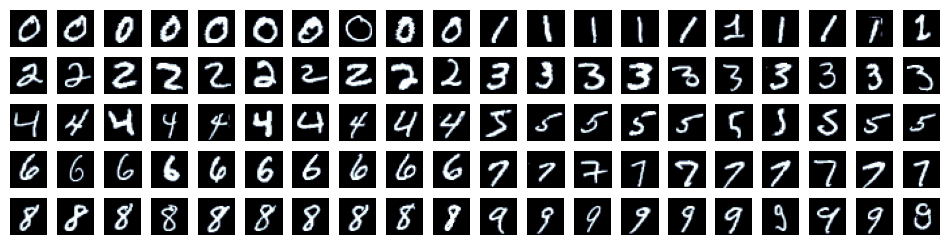

In [ ]:
fig = plt.figure(figsize=(12., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 20),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

indices = np.arange(len(train_val_labels))
for ax, digit in zip(grid, range(100)):
    # Iterating over the grid returns the Axes.
    i = digit % 10
    ax.imshow(Image.fromarray(train_val_images[indices[train_val_labels == digit // 10][i]]), cmap="bone")
    ax.axis("off")
plt.savefig("mnist-sample-100.eps",dpi=300)

In [ ]:
# @title Import Colab GPU
import tensorflow as tf
!pip install tensorflow

In [ ]:
# @title Load MNIST Dataset

mnist = tf.keras.datasets.mnist
(train_images, train_labels), _ = mnist.load_data()

# Reshape images to vectors
digits = train_images.reshape(-1, 784) / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# @title K-Means clustering

k = 10  #number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(digits)

NameError: ignored

In [ ]:
# @title Internal Validation

# Calculate J
distances = pairwise_distances_argmin_min(digits, kmeans.cluster_centers_)[1]
J = sum(distances) / len(digits)

# Calculate Davies-Bouldin index
db_index = davies_bouldin_score(digits, cluster_labels)

# Calculate confusion matrix
confusion = confusion_matrix(train_labels, cluster_labels)

# Calculate purity
purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)

# Calculate Rand Index
rand_index = adjusted_rand_score(train_labels, cluster_labels)

print("Calculation for J :", J)
print("\nConfusion Matrix:")
print(confusion)
print("\nDavies-Bouldin index Index is :", db_index)
print("\nPurity is :", purity)
print("\nRand Index is :", rand_index)

Calculation for J : 6.161187401099331

Confusion Matrix:
[[  21   37 2506  163    3  187   14   17 2794  181]
 [2977    6    0    5 3717   10    9    9    0    9]
 [ 352  174   95  328  365  156   70 4196   10  212]
 [ 102  176  120 3922  427 1040   49  218   19   58]
 [ 309 3189   10    1  159   21 1940   38   10  165]
 [ 795  374  244 1776  161 1523  346   15   65  122]
 [ 222   82  118   28  270   95    1   87  100 4915]
 [ 282 1795   14    5  327   10 3774   39   15    4]
 [ 413  193   31 1142  296 3453  182   56   38   47]
 [ 116 2901   19   86  240   69 2461   13   37    7]]

Davies-Bouldin index Index is : 2.8372662018303907

Purity is : 0.5907166666666667

Rand Index is : 0.3607179625149027


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


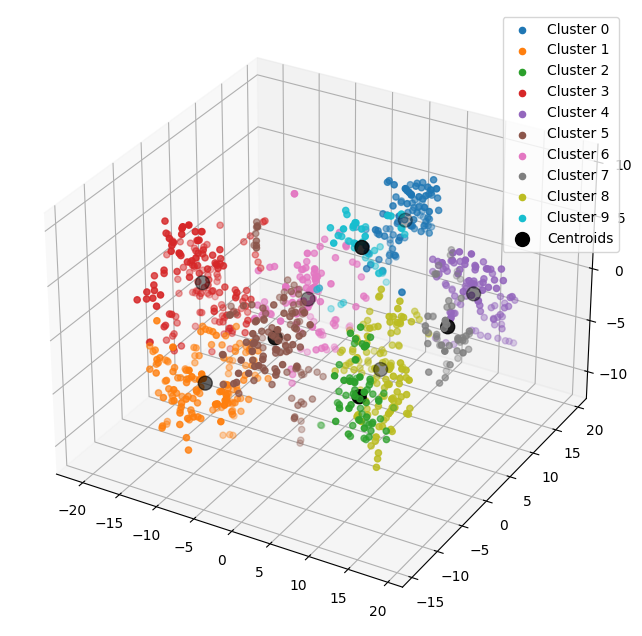

In [ ]:
# @title 3D tSNE Plot

# Reduce dimensions using tSNE
tsne = TSNE(n_components=3, random_state=0)
tsne_result = tsne.fit_transform(digits[:1000])

# Fit K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(tsne_result)

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each cluster
for cluster in range(k):
    cluster_mask = cluster_labels[:1000] == cluster
    ax.scatter(tsne_result[cluster_mask, 0], tsne_result[cluster_mask, 1], tsne_result[cluster_mask, 2], label=f'Cluster {cluster}')

# Plot centroids
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='o', s=100, c='black', label='Centroids')

ax.legend()
plt.show()

#Text Clustering: Reddit Comments Dataset

In [ ]:
# @title Load the Dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/reddit_data.csv')

data

,parent_id,text,topic,length,size_range
0,t1_crojgfu,Thanks! Not sure if those links were up there ...,pcmasterrace,103,101 to 200
1,t1_cquq97y,I think its unlikely someone would kill them s...,news,163,101 to 200
2,t1_cr92xnl,Hoult is another one that's important.\n\nBut ...,movies,99,0 to 100
3,t1_crk6sin,Can have my opinion.\n\nThey're noisy and hot....,pcmasterrace,1556,501 +
4,t1_cr9398p,Nice! That reminds me of a more recent article...,news,252,201 to 500
...,...,...,...,...,...
39996,t1_cr4jdga,But aren't most of the illegal immigrants Cath...,news,425,201 to 500
39997,t1_cr98ybu,Yes because she held him down and forced the c...,news,144,101 to 200
39998,t1_crbzx6n,Six String Samurai is one of my favorite movie...,movies,354,201 to 500
39999,t1_crozy8f,nah this is the kind of comments you get when ...,nfl,890,501 +


In [ ]:
# @title Dropping Nan Values

#detecting Missing Values
missing_values = data['text'].isna().sum()

#removing Nan Values
data.dropna(subset=['text'], inplace=True)
data.reset_index(drop=True, inplace=True)

missing_values

1553

In [ ]:
# @title Clustering Texts and Topic
num_clusters = 5  # Number of clusters

# Extract necessary columns
texts = data['text'].tolist()
topics = data['topic'].tolist()

In [ ]:
# @title Calculating Feature Vectors for the Text Association

# Tokenization
tokenized_texts = [word_tokenize(text) for text in texts]

# Stemming
stemmer = PorterStemmer()
stemmed_texts = [[stemmer.stem(word) for word in text] for text in tokenized_texts]

# Normalize the words
normalized_texts = [[word.lower() for word in text] for text in stemmed_texts]

# Discard stop words
stop_words = set(stopwords.words('english'))
filtered_texts = [[word for word in text if word not in stop_words] for text in normalized_texts]

In [ ]:
# @title Zipf’s Law to Discard Most Frequent and Least Frequent Words

# Initialize an empty dictionary to store word frequencies
word_counts = {}

# Count word frequencies in your corpus
for text in filtered_texts:
    for word in text:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Sort the words by their frequency in descending order
sorted_words = list(word_counts.items())
sorted_words.sort(key=lambda x: x[1], reverse=True)

# Define a threshold (keep the top 10% of words)
threshold = int(0.1 * len(sorted_words))  # Adjust as needed

# Keep words within the threshold range
filtered_words = [word for word, count in sorted_words[threshold:-threshold]]

# Filtering text data to include only the selected words
filtered_texts = []
for text in normalized_texts:
    filtered_text = [word for word in text if word in filtered_words]
    filtered_texts.append(filtered_text)

In [ ]:
# @title Building the Final Vocabulary/Term List

# create the final vocabulary/term list
final_vocabulary = list(set(filtered_words))

# optionally, you can sort the vocabulary alphabetically
final_vocabulary.sort()

# create a list of all unique terms (vocabulary)
vocabulary = final_vocabulary  # Assuming you already have the final vocabulary

In [ ]:
# @title Calculate TF Matrix for All Comments/Documents

#initialize an empty TF matrix
num_documents = len(filtered_texts)
num_terms = len(vocabulary)
tf_matrix = [[0] * num_terms for _ in range(num_documents)]

#calculate TF values for each document and term
for i, document in enumerate(filtered_texts):
    term_count = {}  # Count the occurrences of each term in the document
    for term in document:
        if term in term_count:
            term_count[term] += 1
        else:
            term_count[term] = 1

    #populate the TF matrix for this document
    for j, term in enumerate(vocabulary):
        tf_matrix[i][j] = term_count.get(term, 0)  # If the term is not in the document, set TF to 0

In [ ]:
# @title Calculate Normalized TF Matrix

#calculate TF values for each term in each document
normalized_tf_matrix = []

for document_tf in tf_matrix:
    max_tf = max(document_tf)  # Find the maximum TF value in the document

    #check if max_tf is zero to avoid division by zero
    if max_tf == 0:
        normalized_tf = [0] * len(document_tf)  # Set all TF values to zero
    else:
        normalized_tf = [tf / max_tf for tf in document_tf]  # Normalize TF values

    normalized_tf_matrix.append(normalized_tf)

In [ ]:
# @title Calculate IDF

#calculate the total number of documents in your corpus
total_documents = len(normalized_tf_matrix)  # Assuming you have normalized_tf_matrix

#calculate the number of documents in which each term appears
document_frequency = [0] * len(vocabulary)  # Initialize a list to store document frequencies

for i in range(len(vocabulary)):
    for document_tf in normalized_tf_matrix:
        if document_tf[i] > 0:
            document_frequency[i] += 1

#calculate IDF for each term
idf_values = []
for df in document_frequency:
    idf = math.log(total_documents / (df + 1))  # Adding 1 to avoid division by zero
    idf_values.append(idf)

In [ ]:
# @title Weighted TF-IDF Matrix

# Initialize an empty weighted TF-IDF matrix
weighted_tfidf_matrix = []

# Iterate through each document's TF values
for document_tf in normalized_tf_matrix:
    weighted_tfidf = [tf * idf for tf, idf in zip(document_tf, idf_values)]
    weighted_tfidf_matrix.append(weighted_tfidf)

In [ ]:
# @title Feature Vectors for Corresponding Category

# Initialize an empty matrix to store feature vectors
feature_vectors = []

# Iterate through each document and its corresponding category (topic)
for document_tf, category in zip(normalized_tf_matrix, topics):
    # Create a feature vector with the category as the first feature
    feature_vector = [category] + document_tf
    feature_vectors.append(feature_vector)

In [ ]:
# Print the TF matrix
print("TF Matrix:")
print(tf_matrix)

# Print the normalized TF matrix
print("\nNormalized TF Matrix:")
print(normalized_tf_matrix)

# Print the IDF vector
print("\nIDF Vector:")
print(feature_vector)

TF Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Normalized TF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

IDF Vector:
[6.55360846 5.5793799  5.18055933 ... 4.97988864 5.73684733 5.3083927 ]


In [ ]:
# @title K-mean Clustering with the Feature Vectors

#Number of clusters
num_clusters = 5

#KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Extract the feature vectors (excluding the first feature which is the category)
X = [vector[1:] for vector in feature_vectors]

# Fit the KMeans model to your data
kmeans.fit(X)

# Get the cluster labels for each document
cluster_labels = kmeans.labels_

# Assign the cluster labels to each document in your dataset
data['cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# @title Calculate J

wcss = 0
for i in range(num_clusters):
    cluster_points = [X[j] for j in range(len(X)) if cluster_labels[j] == i]
    centroid = kmeans.cluster_centers_[i]
    wcss += sum([(np.linalg.norm(point - centroid))**2 for point in cluster_points])

# Calculate J
J = wcss / len(X)
print("J Sum of Squares:", J)

J Sum of Squares: 4.814095198517877


In [ ]:
# @title Calculate Davies-Bouldin index
db_index = 0

for i in range(num_clusters):
    max_similarity = -float('inf')

    for j in range(num_clusters):
        if i != j:
            centroid_i = kmeans.cluster_centers_[i]
            centroid_j = kmeans.cluster_centers_[j]

            # Collect the points in cluster i and cluster j
            points_i = [X[idx] for idx, label in enumerate(cluster_labels) if label == i]
            points_j = [X[idx] for idx, label in enumerate(cluster_labels) if label == j]

            # Calculate the scatter of cluster i and cluster j
            scatter_i = sum(np.linalg.norm(point - centroid_i)**2 for point in points_i)
            scatter_j = sum(np.linalg.norm(point - centroid_j)**2 for point in points_j)

            # Calculate the similarity between cluster i and cluster j
            similarity = (scatter_i + scatter_j) / np.linalg.norm(centroid_i - centroid_j)

            if similarity > max_similarity:
                max_similarity = similarity

    db_index += max_similarity

db_index /= num_clusters

print("Davies-Bouldin index:", db_index)

Davies-Bouldin index: 656.010445462035


In [ ]:
# @title Calculate Dunn index
min_intercluster_distance = float('inf')
max_intracluster_distance = -float('inf')

for i in range(num_clusters):
    cluster_points = [X[j] for j in range(len(X)) if cluster_labels[j] == i]
    centroid_i = kmeans.cluster_centers_[i]

    for point in cluster_points:
        intracluster_distance = np.linalg.norm(point - centroid_i)
        if intracluster_distance > max_intracluster_distance:
            max_intracluster_distance = intracluster_distance

    for j in range(num_clusters):
        if i != j:
            centroid_j = kmeans.cluster_centers_[j]
            intercluster_distance = np.linalg.norm(centroid_i - centroid_j)
            if intercluster_distance < min_intercluster_distance:
                min_intercluster_distance = intercluster_distance

dunn_index = min_intercluster_distance / max_intracluster_distance

print("Dunn Index:", dunn_index)

Dunn Index: 0.4812961846055191


In [ ]:
# @title Number of unique categories
unique_categories = set(topics)
num_unique_categories = len(unique_categories)
print("Number of unique categories:", num_unique_categories)

Number of unique categories: 4


In [ ]:
# @title Calculate Rand index
a = b = c = d = 0

for i in range(len(X)):
    for j in range(i+1, len(X)):
        if topics[i] == topics[j] and cluster_labels[i] == cluster_labels[j]:
            a += 1
        elif topics[i] != topics[j] and cluster_labels[i] != cluster_labels[j]:
            b += 1
        elif topics[i] == topics[j] and cluster_labels[i] != cluster_labels[j]:
            c += 1
        elif topics[i] != topics[j] and cluster_labels[i] == cluster_labels[j]:
            d += 1

rand_index = (a + b) / (a + b + c + d)

print("Rand Index: ", rand_index)

Rand Index:  0.22743261142250643


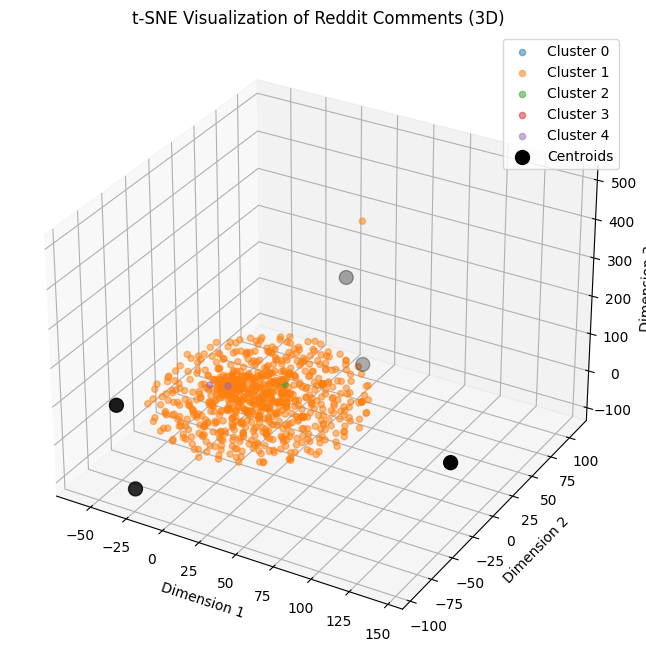

In [ ]:
# @title Plotting the 3D scatter plot using tSNE

# Randomly choose 1000 data points for visualization
random.seed(42)  # Set a seed for reproducibility
indices_to_visualize = random.sample(range(len(X)), 1000)
data_to_visualize = [X[i] for i in indices_to_visualize]

# Convert data_to_visualize to a NumPy array
data_to_visualize = np.array(data_to_visualize)

cluster_labels_to_visualize = [cluster_labels[i] for i in indices_to_visualize]

# Perform t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, perplexity=4, random_state=42)
data_3d = tsne.fit_transform(data_to_visualize)


# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points with different colors for each cluster
for cluster_num in range(num_clusters):
    cluster_indices = [i for i, label in enumerate(cluster_labels_to_visualize) if label == cluster_num]
    cluster_data = [data_3d[i] for i in cluster_indices]
    ax.scatter(
        [point[0] for point in cluster_data],
        [point[1] for point in cluster_data],
        [point[2] for point in cluster_data],
        label=f'Cluster {cluster_num}',
        alpha=0.5,
    )

# Plot centroids with larger markers
centroids_3d = tsne.fit_transform(kmeans.cluster_centers_)
ax.scatter(
    [centroid[0] for centroid in centroids_3d],
    [centroid[1] for centroid in centroids_3d],
    [centroid[2] for centroid in centroids_3d],
    marker='o',
    s=100,  # Adjust marker size as needed
    c='black',  # Color of centroids
    label='Centroids',
)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('t-SNE Visualization of Reddit Comments (3D)')
ax.legend()

plt.show()